# clustering

Cleaned up notebook for the clustering task of this project.

In [105]:
import folium
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler, PowerTransformer
from scipy.stats import kurtosis, skew
import matplotlib as mpl
import pickle

In [8]:
path = '../data/Boston_Housing_Market_Challenge/boston_fixed.csv'

boston = pd.read_csv(path)

In [5]:
# define scalers
def tanh(x):
    return np.tanh(x)

def root(x, power, inverse = False):
    return x ** power if not inverse else x ** 1/power


def log(x, inverse = False):
    return np.log(x) if not inverse else np.exp(x)

def sqrt(x):
    return np.sqrt(x)


#def reflect(x):
#    return np.abs(-x)



def plotting(x, activation = None, normalization = None):
    x_cols = x.columns
    x = np.asarray(x)

    if activation:
        x = activation(x)
        activation = activation.__name__.upper()
    else:
        activation = 'NONE'
        
        
    if normalization:
        x = normalization().fit_transform(x)
        normalization = normalization.__name__.upper()
    else:
        normalization = 'NONE'
        
        

    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16,8))
    fig.suptitle(('The distribution of the data with {} normalization for an activation'
                  ' function of {}'.format(normalization ,activation)), fontsize=16)
    
    for i in range(x.shape[1]):
        ax[0].hist(x[:,i], alpha = 0.2)
    ax[0].legend(x_cols)   
    ax[1] = sns.boxplot(data = x)
    plt.xticks(rotation=15)
    plt.show()

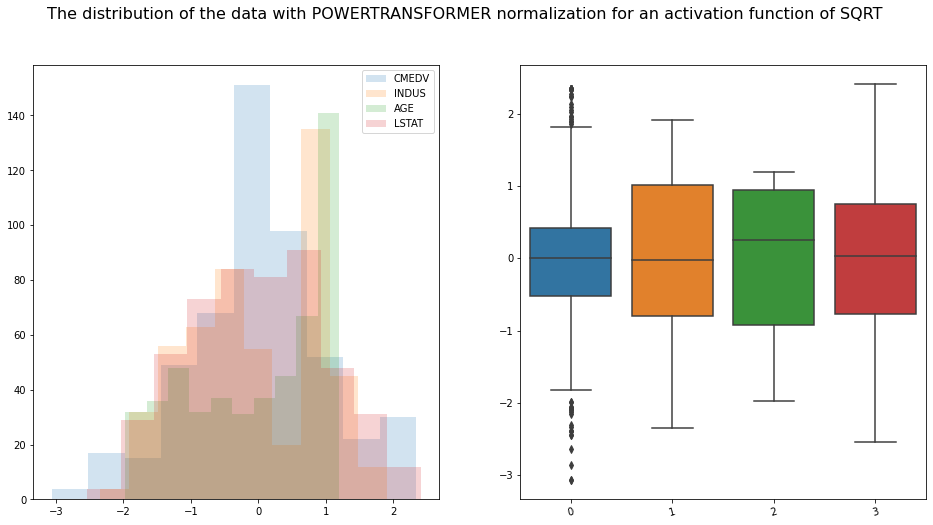

,0,1,2,3
0,0.891203,-1.049669,0.130321,-0.772380
1,0.380510,-1.049669,0.091289,-0.915854
2,0.231115,-1.049669,-0.849814,-0.167940
3,0.846254,-1.049669,-1.283102,-1.156655
4,0.164897,-1.049669,-0.089254,-0.246922
...,...,...,...,...
501,-0.139193,0.402171,0.134236,0.119542
502,0.004807,0.402171,-0.631781,0.172584
503,0.327946,0.402171,-1.922882,-0.803391
504,0.028179,0.402171,-0.921104,-0.370170


In [9]:
my_columns = ['CMEDV','INDUS','AGE','LSTAT']
my_act = sqrt
my_norm = PowerTransformer

change = 1

boston_clust = boston.loc[:,boston.columns.isin(my_columns)]

plotting(boston_clust, activation = my_act, normalization = my_norm)

if change == 1:
  boston_clust = boston_clust.transform(lambda x: np.sqrt(x))
  scaler = PowerTransformer()
  boston_clust = pd.DataFrame(scaler.fit_transform(boston_clust))

boston_clust

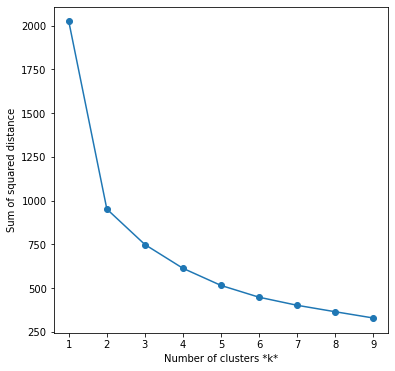

In [10]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(boston_clust)
    sse.append(km.inertia_)

# Plot sse against k 
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [11]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(boston_clust)

clusters = pd.DataFrame(kmeans.predict(boston_clust))

boston['Clusters'] = clusters 

In [119]:
m=folium.Map([42.3557, -71.0572],zoom_start=10, tiles="cartodbpositron",)
from folium.plugins import MarkerCluster, HeatMap
my_col = ['red','khaki','orange','green']
marker_cluster = MarkerCluster().add_to(m)
import branca.colormap as cm

colormap = cm.LinearColormap(colors=['yellow','red'], index=[boston['LSTAT'].min(),boston['LSTAT'].max()],vmin=boston['LSTAT'].min(),vmax=boston['LSTAT'].max())

for lat,lon,clu, lstat in zip(boston['LAT'],boston['LON'],boston['Clusters'], boston['LSTAT']):

    col = my_col[clu]

    
    folium.CircleMarker([lat, lon],
                  radius=10,
                  #fill=False,
                                fill_opacity=0.8,
                               fill_color = col,
                        #fill_color = colormap(lstat),
                  color = 'black',
                        weight = 0.3
                              ).add_to(m)
    
"""for [lat,lon], name in zip(pickle.load(open('../data/other_data/lat_long_centers.pkl', 'rb')), np.unique(boston.TOWN)):
    folium.CircleMarker([lat, lon],
                  radius=5,
                  #fill=False,
                                fill_opacity=0.8,
                               # fill_color = col,
                        fill_color = 'black',
                  color = 'black',
                        weight = 0.3
                              ).add_to(m)"""

m
m.save("clusters.html")

In [121]:
m